# Create all image csv files

In [46]:
import os
import csv

def create_csv(image_folder, csv_file_path):
    # Define the CSV header fields
    fieldnames = ['HospitalID', 'PatientID', 'ImageID', 'ImagePath', 'Label']
    
    # Open the CSV file in write mode
    with open(csv_file_path, 'w', newline='') as csvfile:
        # Create a CSV writer object and write the header
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        # Iterate through files in the folder
        for filename in sorted(os.listdir(image_folder)):
            # Construct the complete image file path
            image_path = os.path.join(image_folder, filename)

            # Parse the filename to extract HospitalID, PatientID, image number, and image label
            parts = filename.split('_')
            hospital_id = parts[3]
            patient_id = parts[1]
            image_number = parts[6]
            image_label = parts[4]

            # Write data into the CSV file
            writer.writerow({
                'HospitalID': hospital_id,
                'PatientID': patient_id,
                'ImageID': image_number,
                'ImagePath': image_path,
                'Label': image_label
            })

    # Print a message indicating that the CSV file has been created and saved
    print("CSV file has been created and saved to:", csv_file_path)


image_folder = "/local/data1/honzh073/data/8bit_downsample_256"
csv_file_path = "/local/data1/honzh073/local_repo/FL/code/3_single_hospital/csv_files/image_data.csv"
create_csv(image_folder, csv_file_path)


CSV file has been created and saved to: /local/data1/honzh073/local_repo/FL/code/3_single_hospital/csv_files/image_data.csv


# Split by patient ID on single hospital

In [47]:
import csv
from collections import defaultdict
import random

def split_and_save_data(input_csv_path, output_folder, target_hospital_ids, train_ratio, seed):
    patient_data = defaultdict(list)
    
    with open(input_csv_path, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if row['HospitalID'] in target_hospital_ids:
                patient_id = row['PatientID']
                patient_data[patient_id].append(row)

    num_patients = len(patient_data)

    num_train = int(num_patients * train_ratio)

    # get random IDs
    all_patient_ids = list(patient_data.keys())

    random.seed(seed)
    random.shuffle(all_patient_ids)

    # split by ID
    train_patients = all_patient_ids[ : num_train]
    test_patients = all_patient_ids[num_train: ]

    # iter by patient IDs
    train_data = []
    test_data = []

    for patient_id, images in patient_data.items():
        if patient_id in train_patients:
            train_data.extend(images)
        elif patient_id in test_patients:
            test_data.extend(images)

    # write to csv
    def write_to_csv(file_path, data):
        with open(file_path, 'w', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=data[0].keys())
            writer.writeheader()
            writer.writerows(data)

    # Write to CSV files
    write_to_csv(os.path.join(output_folder, 'cross_train.csv'), train_data)
    write_to_csv(os.path.join(output_folder, 'cross_test.csv'), test_data)
    
    print("Saved train.csv, test.csv.")

# input and output path
input_csv_path = "/local/data1/honzh073/local_repo/FL/code/3_single_hospital/csv_files/image_data.csv"
output_folder = '/local/data1/honzh073/local_repo/FL/code/3_single_hospital/csv_files/'

# single hospital id
target_hospital_ids = ['43']

# random seed
seed = 1

# train and val dataset ratio
train_ratio = 0.7
# test_ratio = 0.3 # unnecessary

split_and_save_data(input_csv_path, output_folder,
                    train_ratio=train_ratio,
                    target_hospital_ids = target_hospital_ids,
                    seed = seed)


Saved train.csv, test.csv.


In [48]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score

# get training class weight, aff : nff = 2:8
def get_classweight(train_dataset):
    train_nff_count = sum(1 for _, label in train_dataset if label == 0)  # 0 NFF
    train_aff_count = sum(1 for _, label in train_dataset if label == 1)  # 1 AFF
    class_weight_nff = 1 / (2 * (train_nff_count / (train_nff_count + train_aff_count)))
    class_weight_aff = 1 / (2 * (train_aff_count / (train_nff_count + train_aff_count)))
    
    return [class_weight_nff, class_weight_aff] # 0 nff , 1 aff 

# training function
def train_model(train_loader, validation_loader, classweight, num_epochs, lr, step_size, gamma, model_name):
    # Load pre-trained model
    torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')
    
    if model_name == 'resnet18':
        from torchvision.models import resnet18, ResNet18_Weights
        model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
    
    elif model_name == 'resnet50':
        from torchvision.models import resnet50, ResNet50_Weights
        model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        
    elif model_name == 'resnet101':
        from torchvision.models import resnet101, ResNet101_Weights
        model = models.resnet101(weights=ResNet101_Weights.DEFAULT)
         
    elif model_name == 'resnet152':
        from torchvision.models import resnet152, ResNet152_Weights
        model = models.resnet152(weights=ResNet152_Weights.DEFAULT)
        
    elif model_name == 'densenet161':
        from torchvision.models import densenet161, DenseNet161_Weights
        model = models.densenet161(weights=DenseNet161_Weights.DEFAULT)

    elif model_name == 'vgg19':
        from torchvision.models import vgg19, VGG19_Weights
        model = models.vgg19(weights=VGG19_Weights.DEFAULT)
        
    else:
        raise ValueError("Invalid model type. 'vgg19' 'resnet50' 'resnet101' 'resnet152' or 'densenet161'.")
    
    # freeze all layers except fc
    # for param in model.parameters():
    #     param.requires_grad = False
    
    # fc
    num_class = 2
    
    if model_name == 'densenet161':
        in_features = model.classifier.in_features
        model.classifier = nn.Sequential(nn.Dropout(0.5),nn.Linear(in_features, num_class)) # dropout
        # model.classifier = nn.Sequential(nn.Linear(in_features, num_class)) # no dropout
    if model_name == 'vgg19':
        in_features = model.classifier[0].in_features
        model.classifier = nn.Sequential(nn.Dropout(0.5),nn.Linear(in_features, num_class)) # dropout
        # model.classifier = nn.Sequential(nn.Linear(in_features, num_class)) # no dropout
    # fc1 = vgg_model.classifier[0]

    else:
        in_features = model.fc.in_features
        model.fc = nn.Sequential(nn.Dropout(0.5), nn.Linear(in_features, num_class)) # dropout
        # model.fc = nn.Sequential(nn.Linear(in_features, num_class)) # no dropout
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # # DataParallel speed up
    # if torch.cuda.device_count() > 1:
    #     print("multiple GPU:", torch.cuda.device_count())
    #     model = nn.DataParallel(model)
    # else:
    #     print("single GPU")
    #     model = model.to(device)
    
    # loss function and learning rate
    criterion = nn.CrossEntropyLoss(weight=torch.Tensor(classweight).to(device))
    # optimizer = optim.Adam(model.parameters(), lr=lr)
    
    optimizer = optim.RMSprop(model.parameters(), lr=lr)

    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    # # scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    # scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

        
    # Loss, ACC
    train_losses = []
    validation_losses = []
    train_accuracies = []
    validation_accuracies = []
    
    # select best model
    best_validation_accuracy = 0
    best_model = None

    for epoch in range(num_epochs):
        model.train()
        correct_train = 0
        total_train = 0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_accuracy = 100 * correct_train / total_train
        
        model.eval()
        correct_validation_aff = 0
        total_validation_aff = 0
        correct_validation = 0
        total_validation = 0
        validation_loss = 0
        
        with torch.no_grad():
            for images, labels in validation_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total_validation += labels.size(0)
                correct_validation += (predicted == labels).sum().item()
                validation_loss += loss.item()
                # Calculate accuracy for AFF class
                total_validation_aff += torch.sum(labels == 1).item()
                correct_validation_aff += torch.sum((predicted == 1) & (labels == 1)).item()

        validation_accuracy_aff = 100 * correct_validation_aff / total_validation_aff

        # validation accuracy and loss
        validation_accuracy = 100 * correct_validation / total_validation
        validation_loss /= len(validation_loader)
        
        train_losses.append(loss.item())
        validation_losses.append(validation_loss)
        train_accuracies.append(train_accuracy)
        validation_accuracies.append(validation_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, "
            f"train Loss: {loss.item():.4f}, "
            f"val Loss: {validation_loss:.4f}, "
            f"train ACC: {train_accuracy:.2f}%, "
            f"Val ACC: {validation_accuracy:.2f}%")
        
        # scheduler.step()
        scheduler.step()

        # select by high aff ACC
        # if validation_accuracy_aff > best_accuracy:
        #     best_accuracy = validation_accuracy_aff
        #     best_model = model.module if isinstance(model, nn.DataParallel) else model

        if validation_accuracy > best_validation_accuracy:
            best_validation_accuracy = validation_accuracy
            # best_model = model.module  # DataParallel
            best_model = model  # single device
            
    # Plot train/val loss,  accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(validation_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend() 

    plt.show()

    return best_model

def test_model(model, test_dataset, batch_size):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    model.eval()
    
    correct_test = 0
    total_test = 0
    test_loss = 0
    
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        all_predictions = []
        all_labels = []
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            test_loss += loss.item()

    test_accuracy = 100 * correct_test / total_test
    test_loss /= len(test_loader)

    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")
     
    auc_score = roc_auc_score(all_labels, all_predictions)
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    
    # Precision、Recall、F1 Score
    class_labels = {0: 'NFF', 1: 'AFF'}

    classification_rep = classification_report(all_labels, all_predictions, target_names=[class_labels[i] for i in range(len(class_labels))])
    print("AUC:", auc_score)
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(classification_rep)

    plot_roc_curve(all_labels, all_predictions)
    
def plot_roc_curve(all_labels, all_predictions):
    fpr, tpr, thresholds = roc_curve(all_labels, all_predictions)
    roc_auc = roc_auc_score(all_labels, all_predictions)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

def show_image(dataset, num_images=5):
    # Get random indices
    random_indices = np.random.choice(len(dataset), num_images, replace=False)

    # Plot images with truncated names
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(random_indices):
        image, label = dataset[idx]  # Use the dataset directly
        filename = dataset.data[idx][0]  # Get the filename from dataset's internal data attribute
        truncated_filename = filename.split('/')[-1][:15]  # Extract the last part and truncate to 15 characters
        
        # Print the original filename
        print(f"Image location: {filename}")

        plt.subplot(1, num_images, i + 1)
        plt.title(f"Label: {label}")
        plt.imshow(image[0])  # Assuming single-channel (grayscale) image
        # plt.imshow(image[0], cmap='gray')  # Assuming single-channel (grayscale) image

        plt.axis('off')
    plt.show()
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)



training class weight [0.7363636363636363, 1.5576923076923077]
Image location: /local/data1/honzh073/data/8bit_downsample_256/patient_ICRBFMHKPB_hospital_43_NFF_image_4.png
Image location: /local/data1/honzh073/data/8bit_downsample_256/patient_XWSXMJCZWA_hospital_43_NFF_image_1.png
Image location: /local/data1/honzh073/data/8bit_downsample_256/patient_QBRMHNSVII_hospital_43_NFF_image_2.png
Image location: /local/data1/honzh073/data/8bit_downsample_256/patient_GFRVIURAPK_hospital_43_NFF_image_1.png
Image location: /local/data1/honzh073/data/8bit_downsample_256/patient_GVTGRCSQXJ_hospital_43_AFF_image_3.png
Image location: /local/data1/honzh073/data/8bit_downsample_256/patient_QBRMHNSVII_hospital_43_NFF_image_1.png
Image location: /local/data1/honzh073/data/8bit_downsample_256/patient_YKVUJXHELG_hospital_43_NFF_image_2.png
Image location: /local/data1/honzh073/data/8bit_downsample_256/patient_ZHFQURFRCS_hospital_43_AFF_image_2.png
Image location: /local/data1/honzh073/data/8bit_downsampl

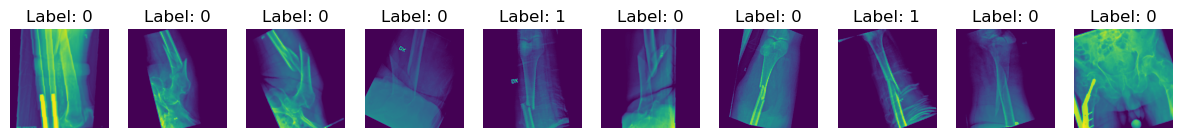

Saved train.csv, val.csv, test.csv.
-----------------------------------
train AFF: 52, ratio: 0.32
----- NFF: 110, ratio: 0.68
-----------------------------------
test AFF: 23, ratio: 0.28
---- NFF: 60, ratio: 0.72


In [49]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import csv
import pandas as pd

import csv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import KFold
from tqdm import tqdm

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = []
        self.labels = []  # Store labels separately
        self.patient_ids = []  # Store patient IDs separately

        self.transform = transform
        # read csv
        with open(csv_file, 'r') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                image_path = row['ImagePath']
                label = row['Label']
                patient_id = row['PatientID']  # Assuming 'PatientID' is the column name in your CSV file

                if label == 'NFF':
                    label = 0
                elif label == 'AFF':
                    label = 1
                else:
                    raise ValueError("Invalid label in CSV file.")
                self.data.append((image_path, label))
                self.labels.append(label)
                self.patient_ids.append(patient_id)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Define your image transformations for training and testing
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.GaussianBlur(kernel_size=3),
    transforms.RandomAdjustSharpness(sharpness_factor=5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the datasets using CustomDataset class
train_dataset = CustomDataset('/local/data1/honzh073/local_repo/FL/code/3_single_hospital/csv_files/cross_train.csv', transform=train_transform)
test_dataset = CustomDataset('/local/data1/honzh073/local_repo/FL/code/3_single_hospital/csv_files/cross_test.csv', transform=test_transform)

# classweight
classweight = get_classweight(train_dataset)
print('training class weight', classweight)

# device
# device = torch.device("cuda:0" if  torch.cuda.is_available() else "cpu")

show_image(train_dataset, 10)

print("Saved train.csv, val.csv, test.csv.")
print('-----------------------------------')
train_NFF_count = sum(1 for _, label in train_dataset if label == 0)  # 0 NFF
train_AFF_count = sum(1 for _, label in train_dataset if label == 1)  # 1 AFF

# For test dataset
test_NFF_count = sum(1 for _, label in test_dataset if label == 0)  # 0 NFF
test_AFF_count = sum(1 for _, label in test_dataset if label == 1)  # 1 AFF


print(f"train AFF: {train_AFF_count}, ratio: {train_AFF_count / (train_AFF_count + train_NFF_count):.2f}")
print(f"----- NFF: {train_NFF_count}, ratio: {train_NFF_count / (train_AFF_count + train_NFF_count):.2f}")
print('-----------------------------------')
print(f"test AFF: {test_AFF_count}, ratio: {test_AFF_count / (test_AFF_count + test_NFF_count):.2f}")
print(f"---- NFF: {test_NFF_count}, ratio: {test_NFF_count / (test_AFF_count + test_NFF_count):.2f}")



In [50]:
def get_classweight(train_dataset):
    train_nff_count = sum(1 for _, label in train_dataset if label == 0)  # 0 NFF
    train_aff_count = sum(1 for _, label in train_dataset if label == 1)  # 1 AFF
    class_weight_nff = 1 / (2 * (train_nff_count / (train_nff_count + train_aff_count)))
    class_weight_aff = 1 / (2 * (train_aff_count / (train_nff_count + train_aff_count)))
    
    return [class_weight_nff, class_weight_aff] # 0 nff , 1 aff


def test_model(model, test_dataset, batch_size):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    model.eval()
    
    correct_test = 0
    total_test = 0
    test_loss = 0
    
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        all_predictions = []
        all_labels = []
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            test_loss += loss.item()

    test_accuracy = 100 * correct_test / total_test
    test_loss /= len(test_loader)

    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")
     
    auc_score = roc_auc_score(all_labels, all_predictions)
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    
    # Precision、Recall、F1 Score
    class_labels = {0: 'NFF', 1: 'AFF'}

    classification_rep = classification_report(all_labels, all_predictions, target_names=[class_labels[i] for i in range(len(class_labels))])
    print("AUC:", auc_score)
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(classification_rep)

    plot_roc_curve(all_labels, all_predictions)

In [51]:
from sklearn.model_selection import StratifiedKFold
from torchvision.models import resnet101, ResNet101_Weights

classweight = get_classweight(train_dataset)

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the ResNet-101 model
model = models.resnet101(weights=ResNet101_Weights.DEFAULT)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # Assuming 2 classes, change it according to your problem
model = model.to(device)

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(classweight).to(device))

optimizer = optim.RMSprop(model.parameters(), lr=0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Define the number of splits for cross-validation
n_splits = 5
# kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)
# Perform k-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(range(len(train_dataset)), train_dataset.patient_ids)):

# for fold, (train_idx, val_idx) in enumerate(kf.split(range(len(train_dataset)))):
    print(f'Fold {fold + 1}/{n_splits}')

    # Create data loaders for training and validation subsets
    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

    train_loader = DataLoader(train_dataset, batch_size=64, sampler=train_sampler)
    val_loader = DataLoader(train_dataset, batch_size=64, sampler=val_sampler)

    # Training loop
    num_epochs = 30  # Choose the number of epochs
        # Loss, ACC
    train_losses = []
    validation_losses = []
    train_accuracies = []
    validation_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        correct_train = 0
        total_train = 0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_accuracy = 100 * correct_train / total_train
        
        model.eval()
        correct_validation_aff = 0
        total_validation_aff = 0
        correct_validation = 0
        total_validation = 0
        validation_loss = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total_validation += labels.size(0)
                correct_validation += (predicted == labels).sum().item()
                validation_loss += loss.item()
                # Calculate accuracy for AFF class
                total_validation_aff += torch.sum(labels == 1).item()
                correct_validation_aff += torch.sum((predicted == 1) & (labels == 1)).item()

        validation_accuracy_aff = 100 * correct_validation_aff / total_validation_aff

        # validation accuracy and loss
        validation_accuracy = 100 * correct_validation / total_validation
        validation_loss /= len(val_loader)
        
        train_losses.append(loss.item())
        validation_losses.append(validation_loss)
        train_accuracies.append(train_accuracy)
        validation_accuracies.append(validation_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, "
            f"train Loss: {loss.item():.4f}, "
            f"val Loss: {validation_loss:.4f}, "
            f"train ACC: {train_accuracy:.2f}%, "
            f"Val ACC: {validation_accuracy:.2f}%")
        scheduler.step()




/local/data1/honzh073/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fold 1/5
Epoch 1/30, train Loss: 0.6290, val Loss: 0.6290, train ACC: 57.36%, Val ACC: 54.55%
Epoch 2/30, train Loss: 0.6346, val Loss: 0.6346, train ACC: 57.36%, Val ACC: 69.70%
Epoch 3/30, train Loss: 0.6044, val Loss: 0.6044, train ACC: 72.09%, Val ACC: 66.67%
Epoch 4/30, train Loss: 0.5767, val Loss: 0.5767, train ACC: 79.07%, Val ACC: 48.48%
Epoch 5/30, train Loss: 0.5592, val Loss: 0.5592, train ACC: 72.09%, Val ACC: 78.79%
Epoch 6/30, train Loss: 0.4961, val Loss: 0.4961, train ACC: 87.60%, Val ACC: 66.67%
Epoch 7/30, train Loss: 0.4722, val Loss: 0.4722, train ACC: 83.72%, Val ACC: 69.70%
Epoch 8/30, train Loss: 0.4423, val Loss: 0.4423, train ACC: 96.12%, Val ACC: 84.85%
Epoch 9/30, train Loss: 0.4782, val Loss: 0.4782, train ACC: 92.25%, Val ACC: 81.82%


In [ ]:

test_model(model=model, test_dataset=test_dataset, batch_size=64)


# ResNet 152

In [ ]:
from sklearn.model_selection import StratifiedKFold
from torchvision.models import resnet152, ResNet152_Weights

classweight = get_classweight(train_dataset)

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the ResNet-101 model
model = models.resnet152(weights=ResNet152_Weights.DEFAULT)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # Assuming 2 classes, change it according to your problem
model = model.to(device)

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(classweight).to(device))

optimizer = optim.RMSprop(model.parameters(), lr=0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Define the number of splits for cross-validation
n_splits = 5
# kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)
# Perform k-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(range(len(train_dataset)), train_dataset.patient_ids)):

# for fold, (train_idx, val_idx) in enumerate(kf.split(range(len(train_dataset)))):
    print(f'Fold {fold + 1}/{n_splits}')

    # Create data loaders for training and validation subsets
    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

    train_loader = DataLoader(train_dataset, batch_size=64, sampler=train_sampler)
    val_loader = DataLoader(train_dataset, batch_size=64, sampler=val_sampler)

    # Training loop
    num_epochs = 50  # Choose the number of epochs
        # Loss, ACC
    train_losses = []
    validation_losses = []
    train_accuracies = []
    validation_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        correct_train = 0
        total_train = 0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_accuracy = 100 * correct_train / total_train
        
        model.eval()
        correct_validation_aff = 0
        total_validation_aff = 0
        correct_validation = 0
        total_validation = 0
        validation_loss = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total_validation += labels.size(0)
                correct_validation += (predicted == labels).sum().item()
                validation_loss += loss.item()
                # Calculate accuracy for AFF class
                total_validation_aff += torch.sum(labels == 1).item()
                correct_validation_aff += torch.sum((predicted == 1) & (labels == 1)).item()

        validation_accuracy_aff = 100 * correct_validation_aff / total_validation_aff

        # validation accuracy and loss
        validation_accuracy = 100 * correct_validation / total_validation
        validation_loss /= len(val_loader)
        
        train_losses.append(loss.item())
        validation_losses.append(validation_loss)
        train_accuracies.append(train_accuracy)
        validation_accuracies.append(validation_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, "
            f"train Loss: {loss.item():.4f}, "
            f"val Loss: {validation_loss:.4f}, "
            f"train ACC: {train_accuracy:.2f}%, "
            f"Val ACC: {validation_accuracy:.2f}%")
        scheduler.step()




In [ ]:

test_model(model=model, test_dataset=test_dataset, batch_size=64)
